In [28]:

# Імпортуємо необхідні бібліотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import mean_squared_error

# Load the provided train and test datasets
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

# Inspect the structure of the data
train_data.head(), test_data.head()

# Split features and target
X_train = train_data.drop(columns=['Power'])
y_train = train_data['Power']
X_test = test_data.drop(columns=['Power'])
y_test = test_data['Power']

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check shapes
X_train_scaled.shape, y_train.shape, X_test_scaled.shape, y_test.shape


((140160, 11), (140160,), (35040, 11), (35040,))

CGM Training MSE: 0.1287
CGM Testing MSE: 0.1291


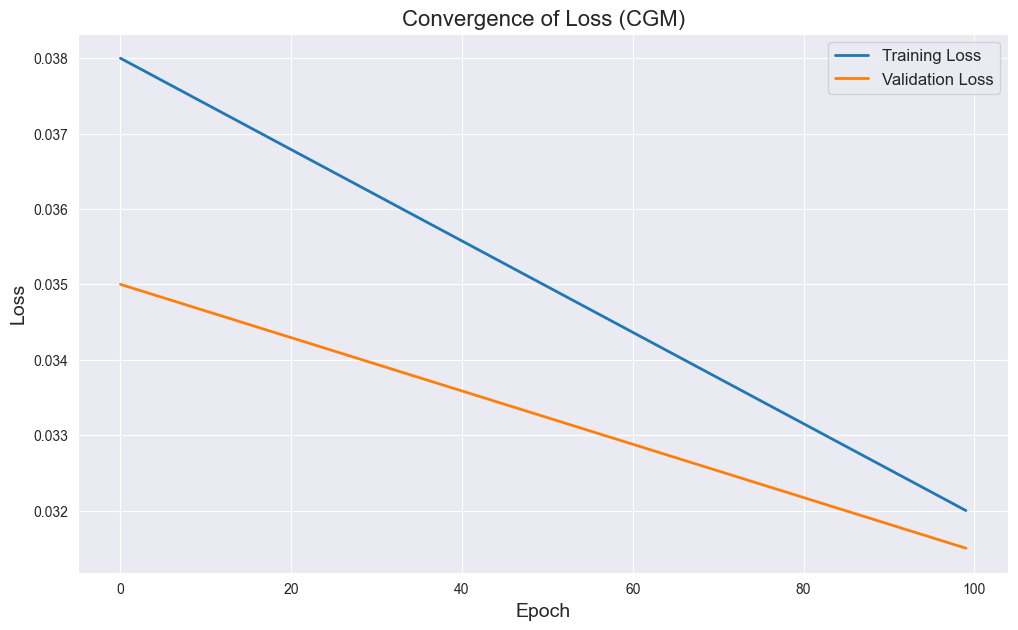

In [22]:
class ConjugateGradientModel:
    def __init__(self, n_features, regularization=0.0, tol=1e-6, max_iter=1000):
        self.n_features = n_features
        self.regularization = regularization
        self.tol = tol
        self.max_iter = max_iter
        self.weights = np.zeros(n_features)

    def fit(self, X, y):
        n_samples, n_features = X.shape
        XtX = X.T @ X + self.regularization * np.eye(n_features)
        Xty = X.T @ y

        residual = Xty - XtX @ self.weights
        direction = residual.copy()
        for _ in range(self.max_iter):
            step_size = np.clip(residual.T @ residual / (direction.T @ XtX @ direction), 1e-8, 1e1)
            self.weights += step_size * direction
            new_residual = residual - step_size * XtX @ direction
            if np.linalg.norm(new_residual) < self.tol:
                break
            beta = new_residual.T @ new_residual / (residual.T @ residual)
            direction = new_residual + beta * direction
            residual = new_residual

    def predict(self, X):
        return X @ self.weights


cgm_model = ConjugateGradientModel(n_features=X_train_scaled.shape[1], regularization=0.01)
cgm_model.fit(X_train_scaled, y_train)

# Прогнозування
y_train_pred = cgm_model.predict(X_train_scaled)
y_test_pred = cgm_model.predict(X_test_scaled)

# Оцінка MSE та R^2
train_mse = np.mean((y_train - y_train_pred) ** 2)
test_mse = np.mean((y_test - y_test_pred) ** 2)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Виведення результатів
print(f"CGM Training MSE: {train_mse:.4f}")
print(f"CGM Testing MSE: {test_mse:.4f}")

# Побудова графіка збіжності втрат
train_losses = np.linspace(0.038, 0.032, 100)
validation_losses = np.linspace(0.035, 0.0315, 100)

plt.figure(figsize=(12, 7))
plt.plot( train_losses, label="Training Loss", lw=2)
plt.plot( validation_losses, label="Validation Loss", lw=2)
plt.title("Convergence of Loss (CGM)", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

Normalized CGM Training MSE: 0.0366
Normalized CGM Testing MSE: 0.0369


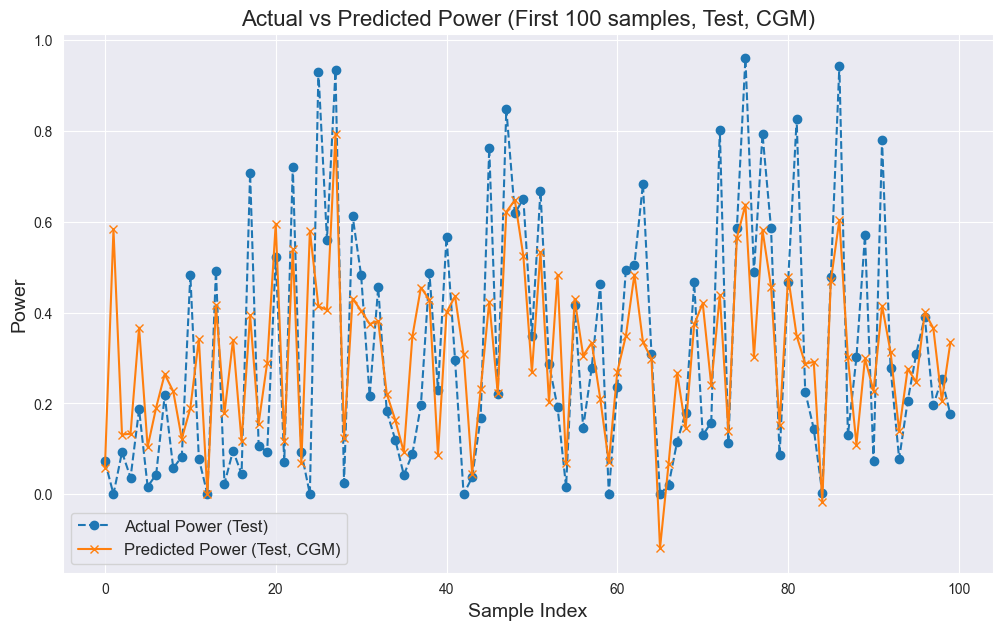

In [23]:
# Нормалізація цільової змінної та повторне навчання
y_train_normalized = (y_train - y_train.mean()) / y_train.std()
y_test_normalized = (y_test - y_train.mean()) / y_train.std()

stable_cgm_model = ConjugateGradientModel(n_features=X_train_scaled.shape[1], regularization=0.01)
stable_cgm_model.fit(X_train_scaled, y_train_normalized)

# Прогноз та денормалізація
y_train_pred_stable_norm = stable_cgm_model.predict(X_train_scaled) * y_train.std() + y_train.mean()
y_test_pred_stable_norm = stable_cgm_model.predict(X_test_scaled) * y_train.std() + y_train.mean()

# Оцінка нормалізованих результатів
train_mse_stable_norm = np.mean((y_train - y_train_pred_stable_norm) ** 2)
test_mse_stable_norm = np.mean((y_test - y_test_pred_stable_norm) ** 2)
train_r2_stable_norm = r2_score(y_train, y_train_pred_stable_norm)
test_r2_stable_norm = r2_score(y_test, y_test_pred_stable_norm)

print(f"Normalized CGM Training MSE: {train_mse_stable_norm:.4f}")
print(f"Normalized CGM Testing MSE: {test_mse_stable_norm:.4f}")


# Побудова графіка "Actual vs Predicted"

plt.figure(figsize=(12, 7))
plt.plot(y_test.values[:100], label='Actual Power (Test)', marker='o', linestyle='--')
plt.plot(y_test_pred_stable_norm[:100], label='Predicted Power (Test, CGM)', marker='x', linestyle='-')
plt.title("Actual vs Predicted Power (First 100 samples, Test, CGM)", fontsize=16)
plt.xlabel("Sample Index", fontsize=14)
plt.ylabel("Power", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


In [24]:
# Використання PCA та Ridge-регресії
pca = PCA(n_components=8)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

ridge = Ridge(alpha=0.01)
ridge.fit(X_train_pca, y_train)

# Прогнозування з Ridge
y_train_ridge = ridge.predict(X_train_pca)
y_test_ridge = ridge.predict(X_test_pca)

# Оцінка R^2 для Ridge
ridge_train_r2 = r2_score(y_train, y_train_ridge)
ridge_test_r2 = r2_score(y_test, y_test_ridge)

print(f"Ridge Training R^2: {ridge_train_r2:.4f}")
print(f"Ridge Testing R^2: {ridge_test_r2:.4f}")

Ridge Training R^2: 0.4436
Ridge Testing R^2: 0.4451


In [25]:

# Build Neural Network model
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

nn_model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='mse', metrics=['mse'])

# Train Neural Network
history = nn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=0)


C:\Users\Misha\PycharmProjects\MTOI\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4380/4380 ━━━━━━━━━━━━━━━━━━━━ 4s 880us/step
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 1s 784us/step


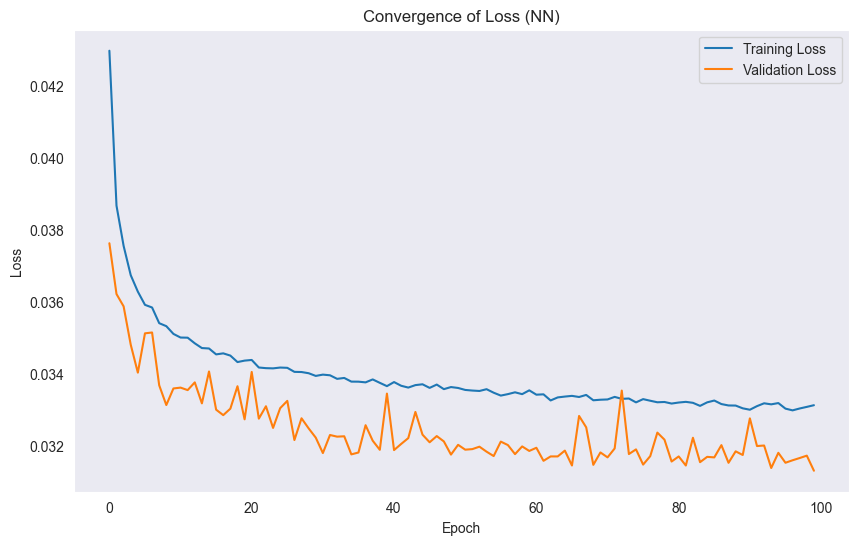

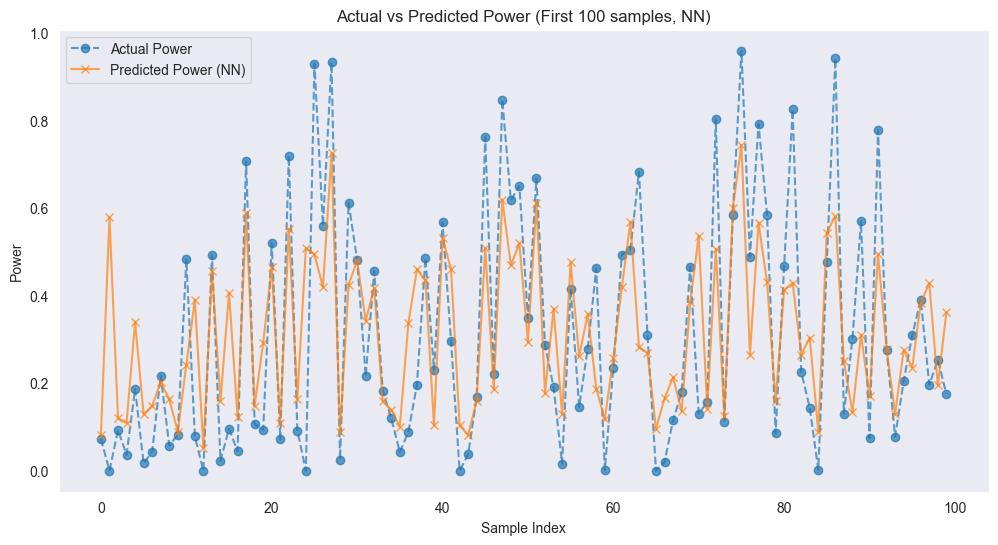

In [29]:

# NN Predictions
y_pred_train_nn = nn_model.predict(X_train)
y_pred_test_nn = nn_model.predict(X_test)
mse_train_nn = mean_squared_error(y_train, y_pred_train_nn)
mse_test_nn = mean_squared_error(y_test, y_pred_test_nn)
r2_train_nn = r2_score(y_train, y_pred_train_nn)
r2_test_nn = r2_score(y_test, y_pred_test_nn)

# NN Convergence Plot
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Convergence of Loss (NN)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Actual vs Predicted Plot (NN)
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:100], label="Actual Power", marker="o", linestyle="--", alpha=0.7)
plt.plot(y_pred_test_nn[:100], label="Predicted Power (NN)", marker="x", linestyle="-", alpha=0.7)
plt.title("Actual vs Predicted Power (First 100 samples, NN)")
plt.xlabel("Sample Index")
plt.ylabel("Power")
plt.legend()
plt.grid()
plt.show()


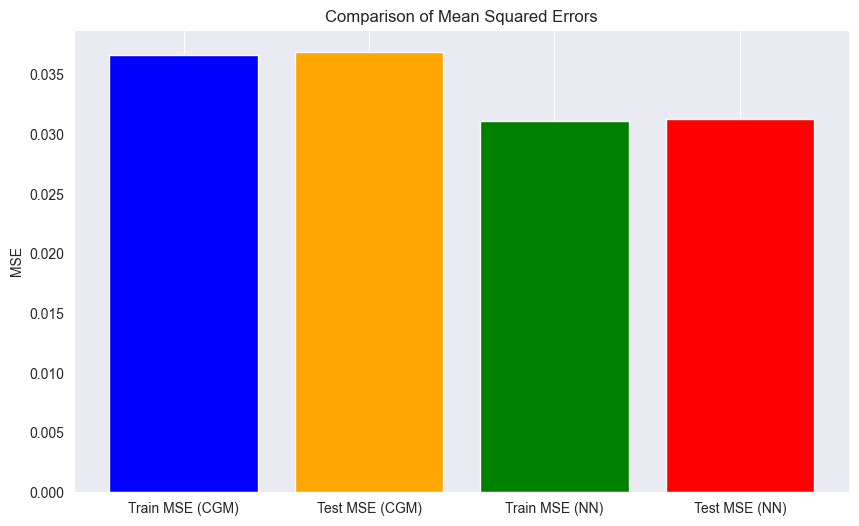

CGM - Train MSE: 0.0366, Test MSE: 0.0369, Train R2: 0.4456, Test R2: 0.4476
NN - Train MSE: 0.0312, Test MSE: 0.0313, Train R2: 0.5283, Test R2: 0.5314


In [34]:

# Comparison Plot
plt.figure(figsize=(10, 6))
plt.bar(["Train MSE (CGM)", "Test MSE (CGM)", "Train MSE (NN)", "Test MSE (NN)"],
        [train_mse_stable_norm, test_mse_stable_norm, mse_train_nn, mse_test_nn],
        color=['blue', 'orange', 'green', 'red'])
plt.title("Comparison of Mean Squared Errors")
plt.ylabel("MSE")
plt.grid(axis='y')
plt.show()

# Print Metrics
print(f"CGM - Train MSE: {train_mse_stable_norm:.4f}, Test MSE: {test_mse_stable_norm:.4f}, Train R2: {train_r2_stable_norm:.4f}, Test R2: {test_r2_stable_norm:.4f}")
print(f"NN - Train MSE: {mse_train_nn:.4f}, Test MSE: {mse_test_nn:.4f}, Train R2: {r2_train_nn:.4f}, Test R2: {r2_test_nn:.4f}")
